In [1]:
%matplotlib widget

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# Bernoulli

In [4]:
def growth_bernoulli(p, q, a, b, f):
    return (1 + f*b)**p * (1-f*a)**q

In [5]:
def kelly_bernoulli(p, q, a, b):
    return (p / a) - (q / b)

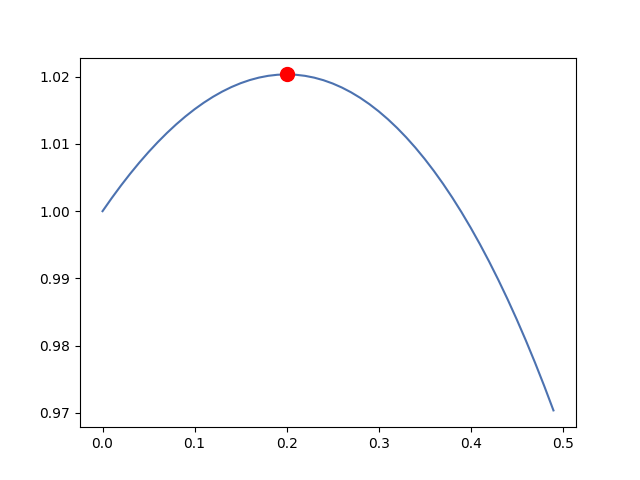

In [6]:
p = 0.6
q = 1 - p
a = 1
b = 1

f_kelly_bernoulli = kelly_bernoulli(p, q, a, b)

plot_range = np.arange(0, 0.5, 0.01)
plt.plot(plot_range, [growth_bernoulli(p, q, a, b, f) for f in plot_range])
plt.plot([f_kelly_bernoulli], [growth_bernoulli(p, q, a, b, f_kelly_bernoulli)], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

# Wiener Process

In [7]:
def growth_wiener(mu, sig, r, f):
    return r + f*(mu - r) - 0.5*(f * sig)**2

In [8]:
def kelly_wiener(mu, sig, r):
    return  (mu - r) / sig**2

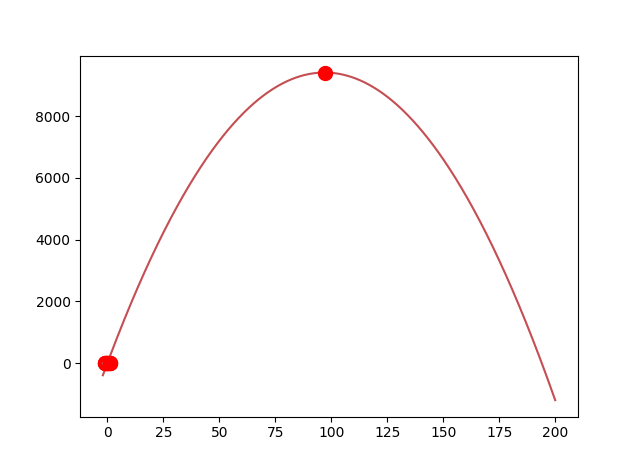

In [14]:
mu = 0.6
sig = 1
r = 1
plot_range = np.arange(-2, 2, 0.01)

for mu in [0, 1, 2]:
    f_kelly_wiener = kelly_wiener(mu, sig, r)
    
    plt.plot(plot_range, [growth_wiener(mu, sig, r, f) for f in plot_range])
    plt.plot([f_kelly_wiener], [growth_wiener(mu, sig, r, f_kelly_wiener)], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
    
plt.show()

# Porfolio of Stocks

In [15]:
def growth_wiener_portfolio(mu, Sig, r, f):
    return r + np.dot(f.T, mu - r) - 0.5*np.sum(f * np.dot(Sig, f), axis=0)

In [16]:
def kelly_wiener_portfolio(mu, Sig, r):
    return  np.dot(np.linalg.inv(Sig), mu - r)

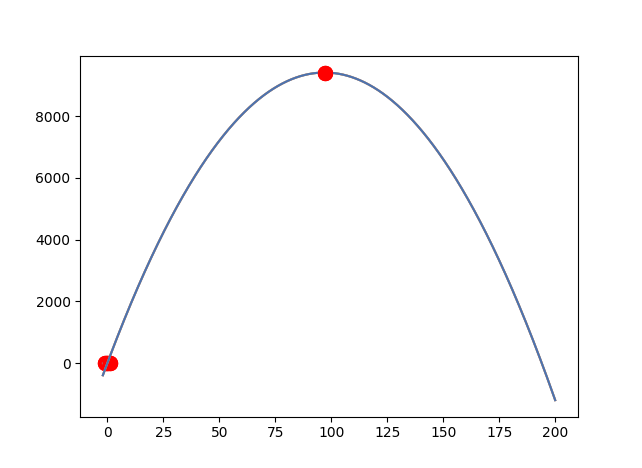

In [18]:
Sig = np.array([[1, 0], [0, 1]])
r = 3
plot_range = np.arange(-2, 200, 0.01)

mu_c = 100
mu = np.array([mu_c, mu_c])

f_kelly_wiener_portfolio = kelly_wiener_portfolio(mu, Sig, r)

plt.plot(plot_range, [growth_wiener_portfolio(mu, Sig, r, np.array([f, f])) for f in plot_range])
plt.plot([f_kelly_wiener_portfolio[0]], [growth_wiener_portfolio(mu, Sig, r, f_kelly_wiener_portfolio)], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")

plt.show()

In [19]:
from mpl_toolkits import mplot3d

In [26]:
Sig = np.array([[1, 0], [0, 1]])
r = 3
mu_c = 0
mu = np.array([mu_c, mu_c])
f_kelly_wiener_portfolio = kelly_wiener_portfolio(mu, Sig, r)


x = np.linspace(-20, 20, 20)
y = np.linspace(-20, 20, 20)

X, Y = np.meshgrid(x, y)
input_data = np.vstack([X.ravel(), Y.ravel()])

Z = growth_wiener_portfolio(mu, Sig, r, input_data).reshape(X.shape)

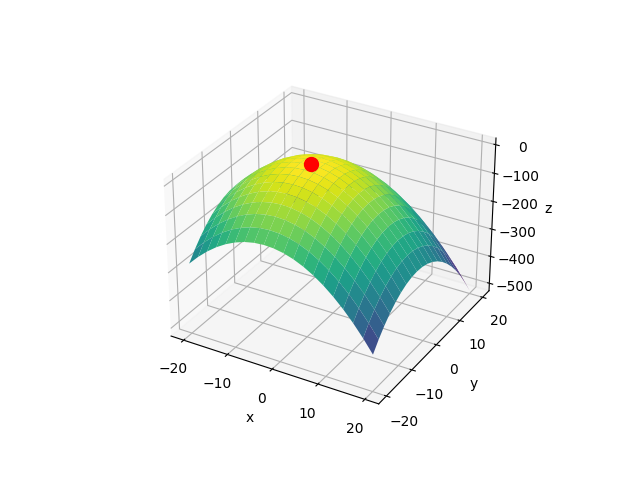

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d', computed_zorder=False)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.plot_wireframe(X, Y, Z, color='gray')
ax.plot3D([f_kelly_wiener_portfolio[0]], [f_kelly_wiener_portfolio[1]], [growth_wiener_portfolio(mu, Sig, r, f_kelly_wiener_portfolio)], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red") 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
df = pd.read_csv("data/stock_prices.csv", parse_dates=True, index_col="date")

In [ ]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [ ]:
ef.portfolio_performance(verbose=True)

In [ ]:
n_samples = 100
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, sharpe_tangent = ef2.portfolio_performance()

stds[n_samples] = std_tangent
rets = np.append(rets, ret_tangent)
sharpes[n_samples] = sharpe_tangent

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
